## Consignes & rappels (à effacer)

Images à utiliser : **Bretagne 24-25**

Vous pourrez acceder à ce dossier depuis votre service Onyxia depuis un terminal de commande. Pour rapatrier des données depuis le serveur de fichier vers votre espace de travail :

1. Ouvrir un terminal
2. Taper la commande ``mc cp -r s3/nom_utilisateur/diffusion/ /home/onyxia/work/data`` (par exemple)

À l’inverse si vous voulez copier les fichiers d’un dossier results par exemple, il faudra rentrer :

``mc cp -r /home/onyxia/work/results s3/nom_utilisateur/diffusion/results``

⚠️ À chaque fois que vous allez ouvrir une nouvelle instance VS Code, il faudra que vous rapatriiez vos données avec cette commande.

**``mc cp -r /home/onyxia/work s3/vt94/diffusion/``**

## Analyse des échantillons


### Nombre d’échantillons

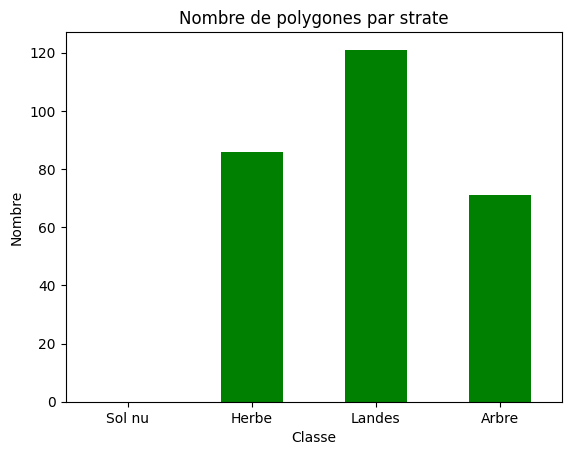

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os

shp_path = os.path.join(
    "data",
    "projet_eval",
    "PI_strates_bretagne_32630.shp"
)

echantillon_shp = gpd.read_file(shp_path)

# Dictionnaire de référence
labels_strates = {
    1: "Sol nu",
    2: "Herbe",
    3: "Landes",
    4: "Arbre"
}

# Compter et forcer les strates attendues
counts = (
    echantillon_shp["strate"]
    .value_counts()
    .reindex(labels_strates.keys())
)

fig, ax = plt.subplots()
counts.plot(kind="bar", ax=ax, color="green")

# Labels de l'axe X depuis le dictionnaire
ax.set_xticks(range(len(counts)))
ax.set_xticklabels([labels_strates[s] for s in counts.index], rotation=0)

# Titres graphique & axes
ax.set_title("Nombre de polygones par strate")
ax.set_xlabel("Classe")
ax.set_ylabel("Nombre")

# Chemin de sortie
output_dir = os.path.join("results", "figure")

os.makedirs(output_dir,exist_ok=True) # Crée le dossier s'il n'existe pas

output_path = os.path.join(output_dir, "diag_baton_nb_poly_by_class.png")

plt.savefig(output_path)

plt.show()

### Phénologie des strates, mise en évidence des landes

## Production d’une d’essences forestières à l’échelle du pixel (titre à changer)

### Choix du classifieur et sa paramétrisation

### Stratégie de validation

### Contribution des variables

### Production des cartes finales

### Analyse des résultats